In [1]:
import torch.utils.data as Data
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
from torch import nn, optim
from torchviz import make_dot

In [2]:
DEVICE = 'cuda'if torch.cuda.is_available() else'cpu'
DEVICE
print(DEVICE)

cpu


In [3]:

transformers = Compose(transforms=[ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_train = CIFAR10(root='./data', train=True, download=True, transform=transformers)
dataset_test = CIFAR10(root='./data', train=False, download=True, transform=transformers)
BATCH_SIZE = 64
num_train = int(0.9*len(dataset_train))
num_val = int(0.1*len(dataset_train))
dataset_train,dataset_val=random_split(dataset_train,[num_train,num_val])
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
img,label = dataset_train[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (numeric): 3
Label (textual): cat


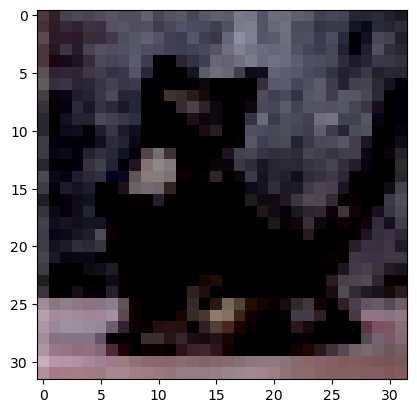

In [5]:
img, label = dataset_train[4]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


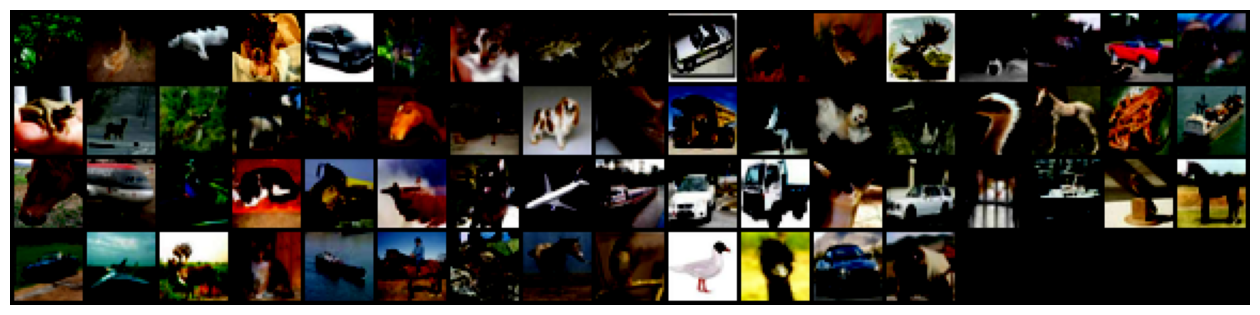

In [7]:
for images, _ in dataloader_train:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,7))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=17).permute((1, 2, 0)))
    break
     

## AlexNet

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )
        
        
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)  
        self.fc2 = nn.Linear(1024, 512)  
        self.fc3 = nn.Linear(512, 10) 

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [9]:
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): 

In [10]:

Loss = []   
Accuracy = []  
def train_runner(model, device, trainloader, optimizer, epoch):
    model.train()
    total = 0
    correct = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = F.cross_entropy(outputs, labels)
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            Loss.append(loss.item())
            Accuracy.append(correct / total)
    return loss.item(), 100 * correct / total
def test_runner(model, device, testloader):
    model.eval()  
    
    correct = 0.0
    test_loss = 0.0
    total = 0
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data).to(device)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            total += label.size(0)
            correct += (predict == label).sum().item()
    
    print("Test Loss: {:.6f}, Test Accuracy: {:.6f}%".format(test_loss / total, 100 * (correct / total)))
    
    return test_loss / total, 100 * correct / total


BATCH_SIZE = 64
EPOCHS = 20
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []


for epoch in range(1, EPOCHS + 1):
    t_loss, t_acc = train_runner(model, DEVICE, dataloader_train, optimizer, epoch)
    print("Epoch {} \t Train Loss: {:.6f}, Train Accuracy: {:.6f}%".format(epoch, t_loss, t_acc))
    

    Train_Loss.append(t_loss)
    Train_Accuracy.append(t_acc)

    v_loss, v_acc = train_runner(model, DEVICE, dataloader_val, optimizer, epoch)
    print("Validation Loss: {:.6f}, Validation Accuracy: {:.6f}%".format(v_loss, v_acc))
    

    Valid_Loss.append(v_loss)
    Valid_Accuracy.append(v_acc)
    

    test_runner(model, DEVICE, dataloader_test)
    print('\n')


Epoch 1 	 Train Loss: 2.282088, Train Accuracy: 14.895556%
Validation Loss: 2.265384, Validation Accuracy: 21.080000%
Test Loss: 0.035622, Test Accuracy: 20.600000%


Epoch 2 	 Train Loss: 1.976851, Train Accuracy: 22.684444%
Validation Loss: 2.097568, Validation Accuracy: 27.740000%
Test Loss: 0.030574, Test Accuracy: 27.630000%


Epoch 3 	 Train Loss: 1.524929, Train Accuracy: 32.295556%
Validation Loss: 2.033874, Validation Accuracy: 37.820000%
Test Loss: 0.027071, Test Accuracy: 36.150000%


Epoch 4 	 Train Loss: 1.267810, Train Accuracy: 39.424444%
Validation Loss: 1.515979, Validation Accuracy: 43.160000%
Test Loss: 0.024520, Test Accuracy: 41.750000%


Epoch 5 	 Train Loss: 1.529859, Train Accuracy: 44.297778%
Validation Loss: 1.887514, Validation Accuracy: 46.920000%
Test Loss: 0.022465, Test Accuracy: 47.230000%


Epoch 6 	 Train Loss: 1.032145, Train Accuracy: 48.797778%
Validation Loss: 1.612560, Validation Accuracy: 50.940000%
Test Loss: 0.021416, Test Accuracy: 50.090000%


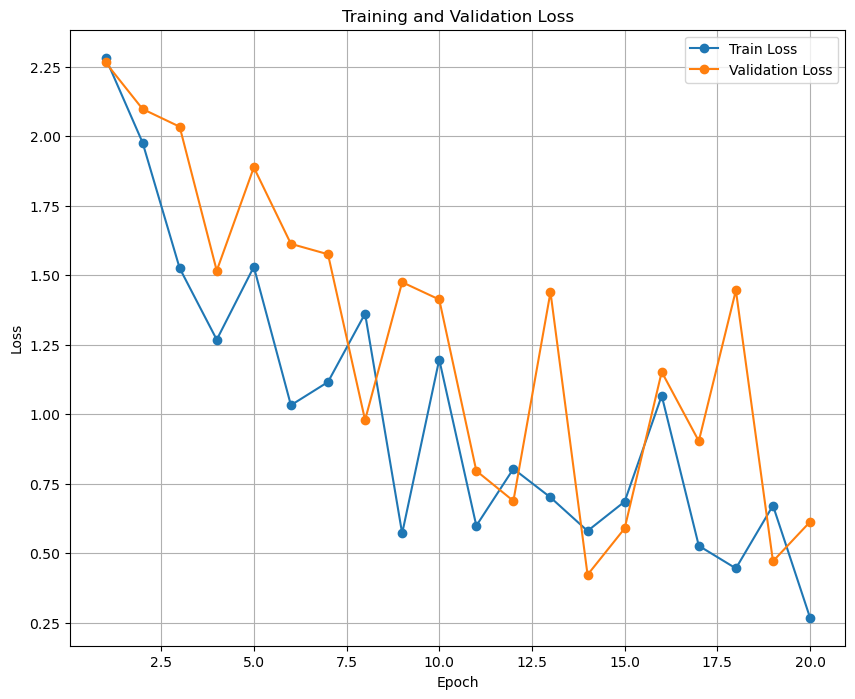

In [11]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, Train_Loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, Valid_Loss, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

    




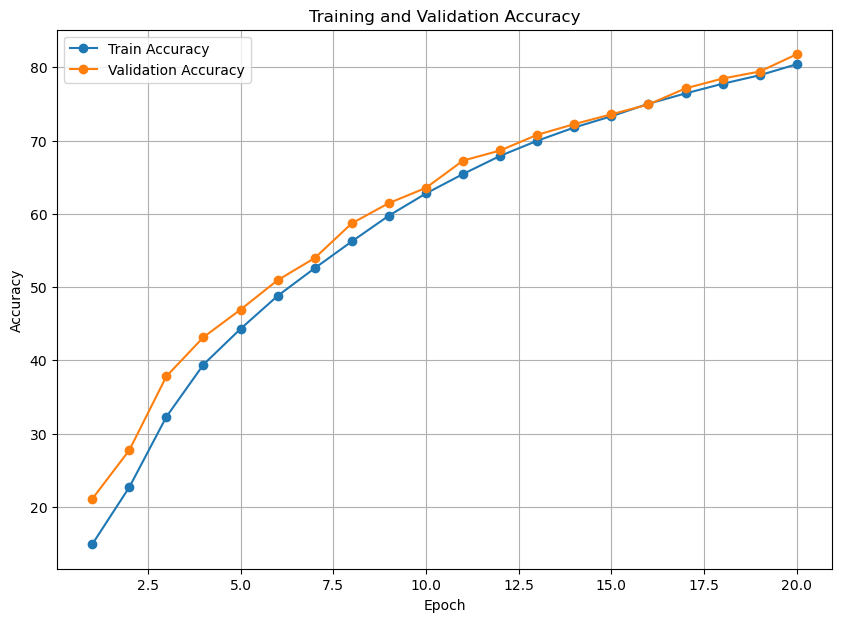

In [12]:

epochs = range(1, EPOCHS + 1)


plt.figure(figsize=(10, 7))
plt.plot(epochs, Train_Accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, Valid_Accuracy, label='Validation Accuracy', marker='o', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.grid(True)
plt.show()

## Vgg_16Net

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class VGG16Net(nn.Module):
    def __init__(self):
        super(VGG16Net, self).__init__()
        
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)  
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)


VGG16Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [14]:
import torch.nn.functional as F

Loss = []   
Accuracy = []


def train_runner(model, device, trainloader, optimizer, epoch):
    model.train()  
    total = 0
    correct = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        outputs = model(inputs)  
        loss = F.cross_entropy(outputs, labels)  
        predict = outputs.argmax(dim=1)  
        
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        
        loss.backward()  
        optimizer.step()  
        
        
        if i % 1000 == 0:
            Loss.append(loss.item())
            Accuracy.append(correct / total)
    
    return loss.item(), 100 * correct / total


def test_runner(model, device, testloader):
    model.eval()  
    correct = 0.0
    test_loss = 0.0
    total = 0
    with torch.no_grad():  
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            
            total += label.size(0)
            correct += (predict == label).sum().item()

    print("Test Loss: {:.6f}, Test Accuracy: {:.6f}%".format(test_loss / total, 100 * (correct / total)))
    
    return test_loss / total, 100 * correct / total
BATCH_SIZE = 64
EPOCHS = 20
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []

for epoch in range(1, EPOCHS + 1):
    t_loss, t_acc = train_runner(model, DEVICE, dataloader_train, optimizer, epoch)
    print("Epoch {} \t Train Loss: {:.6f}, Train Accuracy: {:.6f}%".format(epoch, t_loss, t_acc))
    
    Train_Loss.append(t_loss)
    Train_Accuracy.append(t_acc)
    
    v_loss, v_acc = train_runner(model, DEVICE, dataloader_val, optimizer, epoch)
    print("Validation Loss: {:.6f}, Validation Accuracy: {:.6f}%".format(v_loss, v_acc))
    
    Valid_Loss.append(v_loss)
    Valid_Accuracy.append(v_acc)
  
    test_runner(model, DEVICE, dataloader_test)
    print('\n')


Epoch 1 	 Train Loss: 2.305352, Train Accuracy: 9.815556%
Validation Loss: 2.301545, Validation Accuracy: 10.300000%
Test Loss: 0.036151, Test Accuracy: 10.000000%


Epoch 2 	 Train Loss: 2.304593, Train Accuracy: 9.957778%
Validation Loss: 2.304857, Validation Accuracy: 10.060000%
Test Loss: 0.036151, Test Accuracy: 10.000000%


Epoch 3 	 Train Loss: 2.304148, Train Accuracy: 9.806667%
Validation Loss: 2.300198, Validation Accuracy: 9.480000%
Test Loss: 0.036151, Test Accuracy: 10.000000%


Epoch 4 	 Train Loss: 2.306656, Train Accuracy: 9.606667%
Validation Loss: 2.299151, Validation Accuracy: 9.860000%
Test Loss: 0.036151, Test Accuracy: 10.000000%


Epoch 5 	 Train Loss: 2.303089, Train Accuracy: 9.713333%
Validation Loss: 2.303737, Validation Accuracy: 9.880000%
Test Loss: 0.036151, Test Accuracy: 10.000000%


Epoch 6 	 Train Loss: 2.300402, Train Accuracy: 9.646667%
Validation Loss: 2.307287, Validation Accuracy: 9.640000%
Test Loss: 0.036151, Test Accuracy: 10.000000%


Epoch 7 

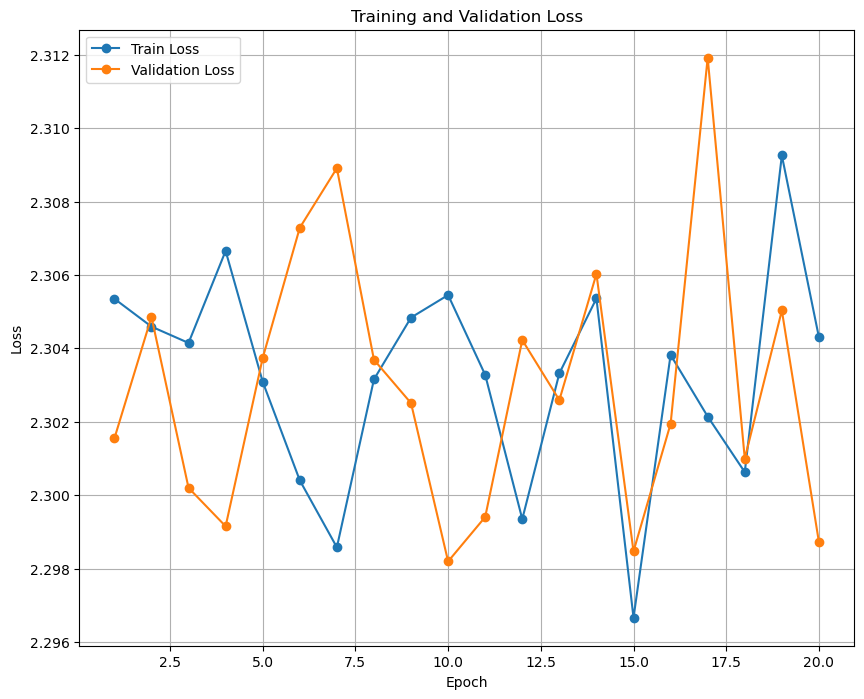

In [15]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, Train_Loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, Valid_Loss, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



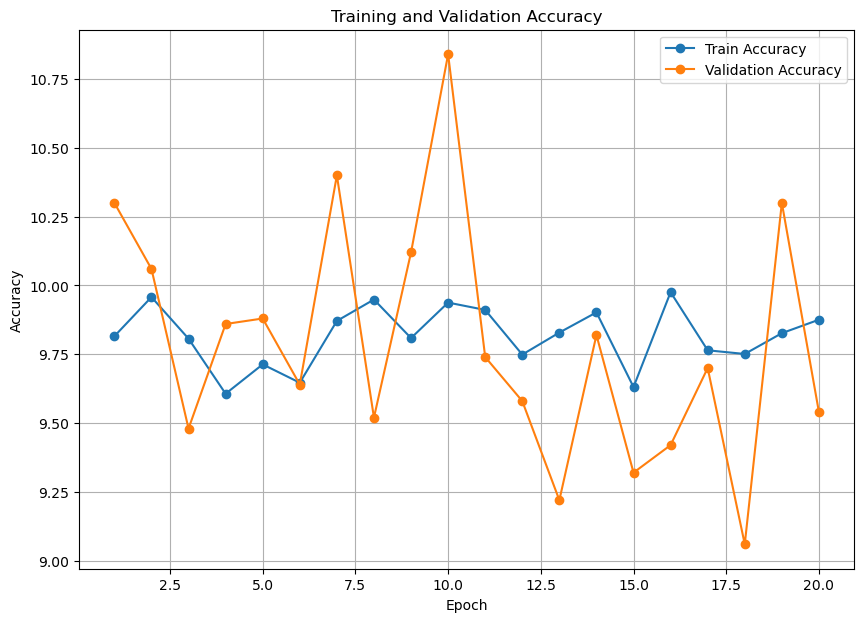

In [16]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, Train_Accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, Valid_Accuracy, label='Validation Accuracy', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## ResNet

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
def conv3x3(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                     stride=stride, padding=padding, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.mid_channels = out_channels // 4

        self.conv1 = conv3x3(in_channels, self.mid_channels, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(self.mid_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(self.mid_channels, self.mid_channels)
        self.bn2 = nn.BatchNorm2d(self.mid_channels)

        self.conv3 = conv3x3(self.mid_channels, out_channels, kernel_size=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.downsample_0 = conv3x3(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            residual = self.downsample(x)
        else:
            residual = self.downsample_0(x)

        out += residual
        out = self.bn3(out)
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        self.conv = conv3x3(3, 64, kernel_size=7, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(3, 2, padding=1)


        self.layer1 = self.make_layer(block, 64, 256, layers[0])
        self.layer2 = self.make_layer(block, 256, 512, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 512, 1024, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 1024, 2048, layers[3], stride=2)


        self.avg_pool = nn.AvgPool2d(3, stride=1, padding=1)
        self.fc = nn.Linear(math.ceil(1) * math.ceil(1) * 2048, num_classes)

    def make_layer(self, block, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                conv3x3(in_channels, out_channels, kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(in_channels, out_channels, stride, downsample))
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.max_pool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(-1, math.ceil(1) * math.ceil(1) * 2048)
        out = self.fc(out)

        return out

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(DEVICE)
print(model_3)

optimizer_3 = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)



ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample_0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ResidualBlock(
    

In [18]:
BATCH_SIZE = 64
EPOCHS = 20

Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []

for epoch in range(1, EPOCHS + 1):
    
    t_loss, t_acc = train_runner(model_3, DEVICE, dataloader_train, optimizer_3, epoch)
    print("Epoch {} \t Train Loss: {:.6f}, Train Accuracy: {:.6f}%".format(epoch, t_loss, t_acc))
    
    
    Train_Loss.append(t_loss)
    Train_Accuracy.append(t_acc)
    
    
    v_loss, v_acc = train_runner(model_3, DEVICE, dataloader_val, optimizer_3, epoch)
    print("Validation Loss: {:.6f}, Validation Accuracy: {:.6f}%".format(v_loss, v_acc))
    
    
    Valid_Loss.append(v_loss)
    Valid_Accuracy.append(v_acc)
    
   
    test_runner(model_3, DEVICE, dataloader_test)
    print('\n')


Epoch 1 	 Train Loss: 2.417524, Train Accuracy: 22.671111%
Validation Loss: 2.193668, Validation Accuracy: 21.200000%
Test Loss: 0.036418, Test Accuracy: 10.000000%


Epoch 2 	 Train Loss: 2.243517, Train Accuracy: 23.368889%
Validation Loss: 1.468689, Validation Accuracy: 28.620000%
Test Loss: 0.043422, Test Accuracy: 9.940000%


Epoch 3 	 Train Loss: 2.599287, Train Accuracy: 30.680000%
Validation Loss: 1.963024, Validation Accuracy: 34.720000%
Test Loss: 0.044010, Test Accuracy: 11.890000%


Epoch 4 	 Train Loss: 1.430521, Train Accuracy: 36.488889%
Validation Loss: 1.717666, Validation Accuracy: 38.260000%
Test Loss: 0.044131, Test Accuracy: 10.950000%


Epoch 5 	 Train Loss: 2.268571, Train Accuracy: 40.444444%
Validation Loss: 1.837278, Validation Accuracy: 43.940000%
Test Loss: 0.043264, Test Accuracy: 11.560000%


Epoch 6 	 Train Loss: 1.709566, Train Accuracy: 43.413333%
Validation Loss: 1.933592, Validation Accuracy: 44.220000%
Test Loss: 0.041645, Test Accuracy: 11.870000%



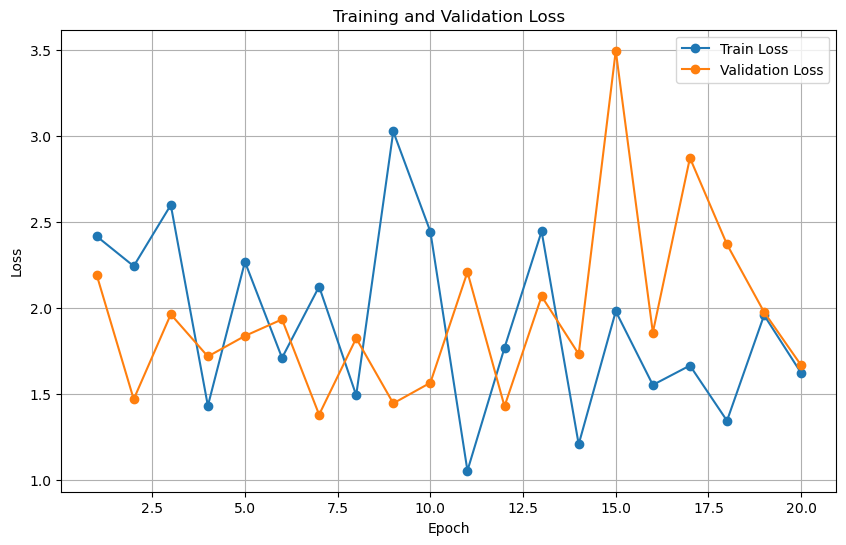

In [19]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, Valid_Loss, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

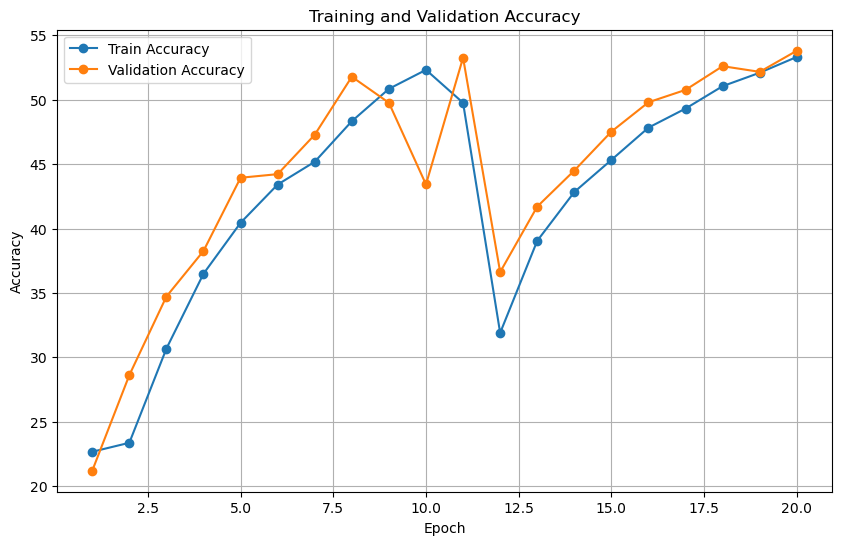

In [20]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, Valid_Accuracy, label='Validation Accuracy', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
     